In [109]:
%matplotlib inline

from hftcryptoapi import BitmartClient
from hftcryptoapi.bitmart.data import *
from datetime import datetime, timedelta
import pandas as pd
from typing import List, Dict, Any

client = BitmartClient()
symbol = "BTCUSDT"
to_time = datetime.now()
from_time = to_time - timedelta(days=30)
klines = client.get_symbol_kline(symbol=symbol, market=Market.FUTURES, tf=TimeFrame.tf_1h, from_time=from_time, to_time=to_time)


def to_dataframe(kl: List[Kline]) -> pd.DataFrame:
    data = [dict(timestamp=k.date_time, open=k.open, high=k.high, low=k.low, close=k.close) for k in kl]

    df = pd.DataFrame(data=data, columns=["timestamp", "open", "high", "low", "close"])
    df.set_index("timestamp", inplace=True)
    return df

df = to_dataframe(klines)
df

,open,high,low,close
timestamp,,,,
2022-11-18 15:30:01,16731.4,16839.80,16716.7,16759.9
2022-11-18 16:30:01,16760.0,16778.90,16705.5,16744.1
2022-11-18 17:30:01,16744.0,16779.90,16740.1,16767.6
2022-11-18 18:30:01,16767.4,16807.10,16725.6,16743.2
2022-11-18 19:30:01,16743.3,16776.10,16647.3,16690.5
...,...,...,...,...
2022-12-18 11:30:01,16732.0,16735.90,16709.5,16727.9
2022-12-18 12:30:01,16727.9,16749.05,16727.8,16739.9
2022-12-18 13:30:01,16739.9,16758.10,16730.0,16745.2


<AxesSubplot: xlabel='timestamp'>

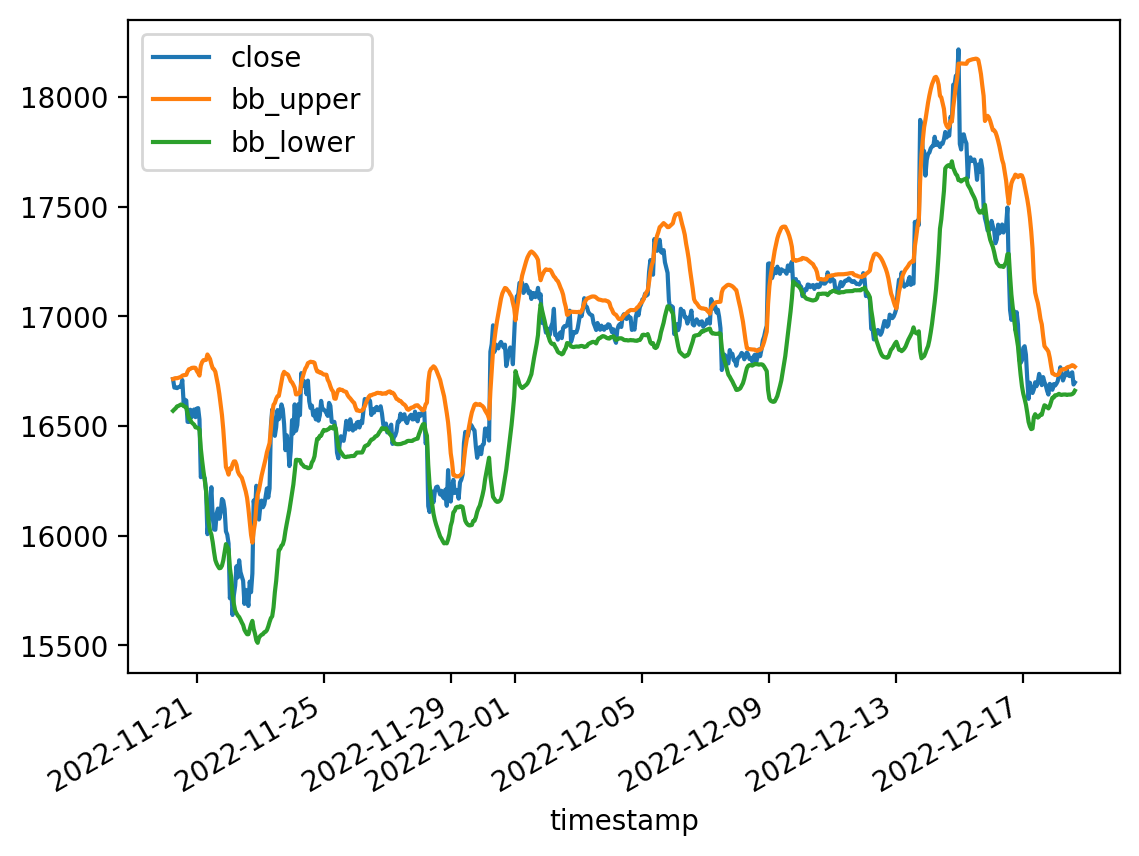

In [112]:
from ta.momentum import rsi
from ta.volatility import BollingerBands

BB_WINDOW = 20
RSI_WINDOW = 14

def add_indicators(df: pd.DataFrame, rsi_window: int = RSI_WINDOW, bb_window: int = BB_WINDOW):
    df["rsi"] = rsi(df.close, window=rsi_window)
    bb = BollingerBands(df.close, window=bb_window)
    df["bb_upper"] = bb.bollinger_hband()
    df['bb_lower'] = bb.bollinger_lband()
    df.dropna(inplace=True)

    return df

add_indicators(df)

df[["close", "bb_upper", "bb_lower"]].plot()

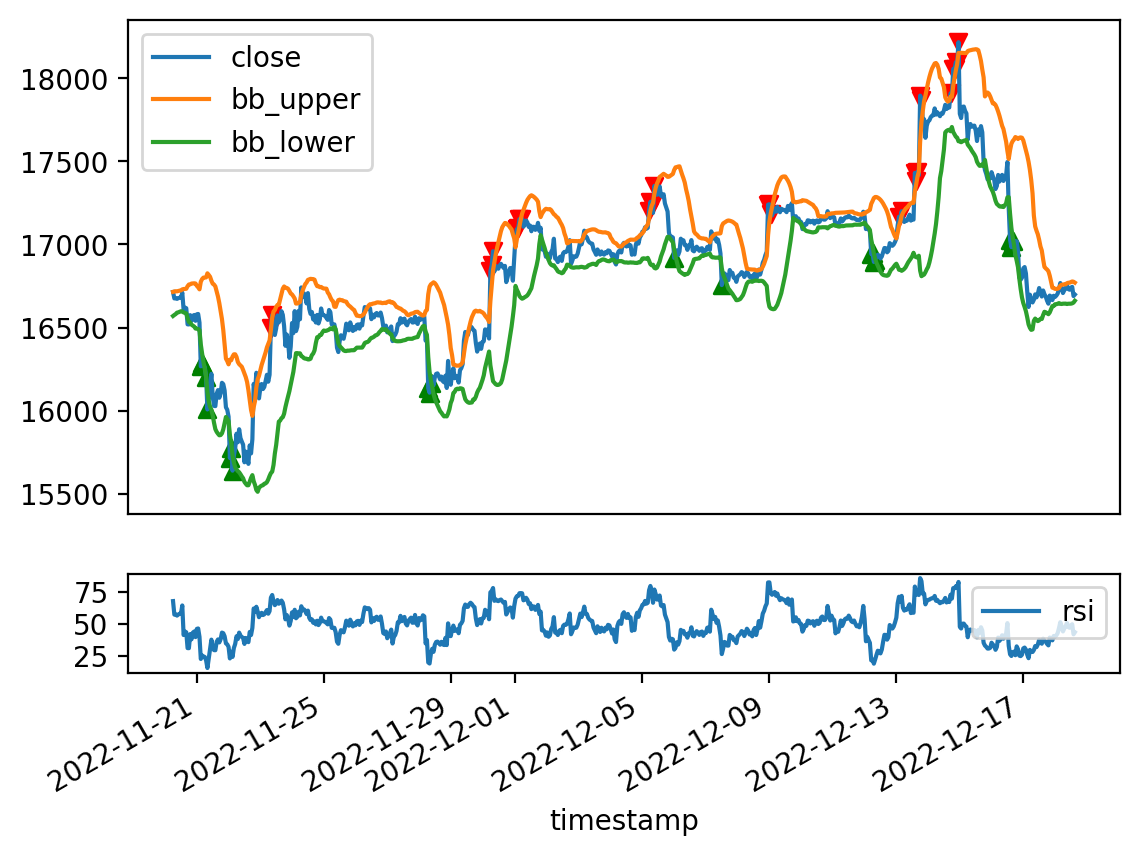

In [121]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, sharex="row", gridspec_kw={"height_ratios": [5, 1]})

df[["close", "bb_upper", "bb_lower"]].plot(ax=axs[0])
df.rsi.plot(ax=axs[1], label="rsi")
axs[1].legend()
axs[0].get_xaxis().set_visible(False)

def should_buy(r: pd.Series) -> bool:
    return r.rsi < 30 and r.close < r.bb_lower


def should_sell(r: pd.Series) -> bool:
    return r.rsi > 70 and r.close > r.bb_upper

df['buy_signal'] = df.apply(should_buy, axis=1)
df['sell_signal'] = df.apply(should_sell, axis=1)


df_buy = df[df.buy_signal]
df_sell = df[df.sell_signal]

axs[0].scatter(df_buy.index, df_buy.close, marker="^", color="green")
axs[0].scatter(df_sell.index, df_sell.close, marker="v", color="red")

plt.show()




In [117]:
trades: List[Dict[str, Any]] = []
entry_side = None
entry_price = None

def open(side: Position, price: float):
    global entry_side, entry_price
    entry_side = side
    entry_price = price

def close(price: float, close_time: datetime):
    global entry_side, entry_price
    trades.append(dict(open_price=entry_price, close_price=price, side=entry_side, close_time=close_time))
    entry_side = None
    entry_price = None


for i, row in df[df.buy_signal | df.sell_signal].iterrows():
    if row.buy_signal and entry_side != Position.LONG:
        if entry_side is None:
            open(Position.LONG, row.close)
        else:
            close(row.close, i)

    if row.sell_signal and entry_side != Position.SHORT:
        if entry_side is None:
            open(Position.SHORT, row.close)
        else:
            close(row.close, i)

trades_df = pd.DataFrame(trades)
trades_df.set_index("close_time", inplace=True)

trades_df

,open_price,close_price,side
close_time,,,
2022-11-23 07:30:01,16267.2,16498.9,1
2022-11-28 06:30:01,16575.5,16135.3,2
2022-11-30 05:30:01,16108.4,16839.3,1
2022-12-06 00:30:01,16873.9,16919.6,2
2022-12-08 23:30:01,16755.7,17240.0,1
2022-12-12 05:30:01,17242.0,16943.6,2
2022-12-13 02:30:01,16946.2,17167.5,1
2022-12-16 14:30:01,17200.0,17029.1,2


In [118]:
def get_profit(side: Position, open_price: float, close_price: float):
    if side == Position.SHORT:
        return (open_price - close_price) / open_price * 100
    else:
        return (close_price - open_price) / close_price * 100

trades_df["profit"] = trades_df.apply(lambda r: get_profit(r.side, r.open_price, r.close_price), axis=1)

trades_df

,open_price,close_price,side,profit
close_time,,,,
2022-11-23 07:30:01,16267.2,16498.9,1,1.404336
2022-11-28 06:30:01,16575.5,16135.3,2,2.655727
2022-11-30 05:30:01,16108.4,16839.3,1,4.340442
2022-12-06 00:30:01,16873.9,16919.6,2,-0.270832
2022-12-08 23:30:01,16755.7,17240.0,1,2.809165
2022-12-12 05:30:01,17242.0,16943.6,2,1.730658
2022-12-13 02:30:01,16946.2,17167.5,1,1.289064
2022-12-16 14:30:01,17200.0,17029.1,2,0.993605


<AxesSubplot: xlabel='close_time'>

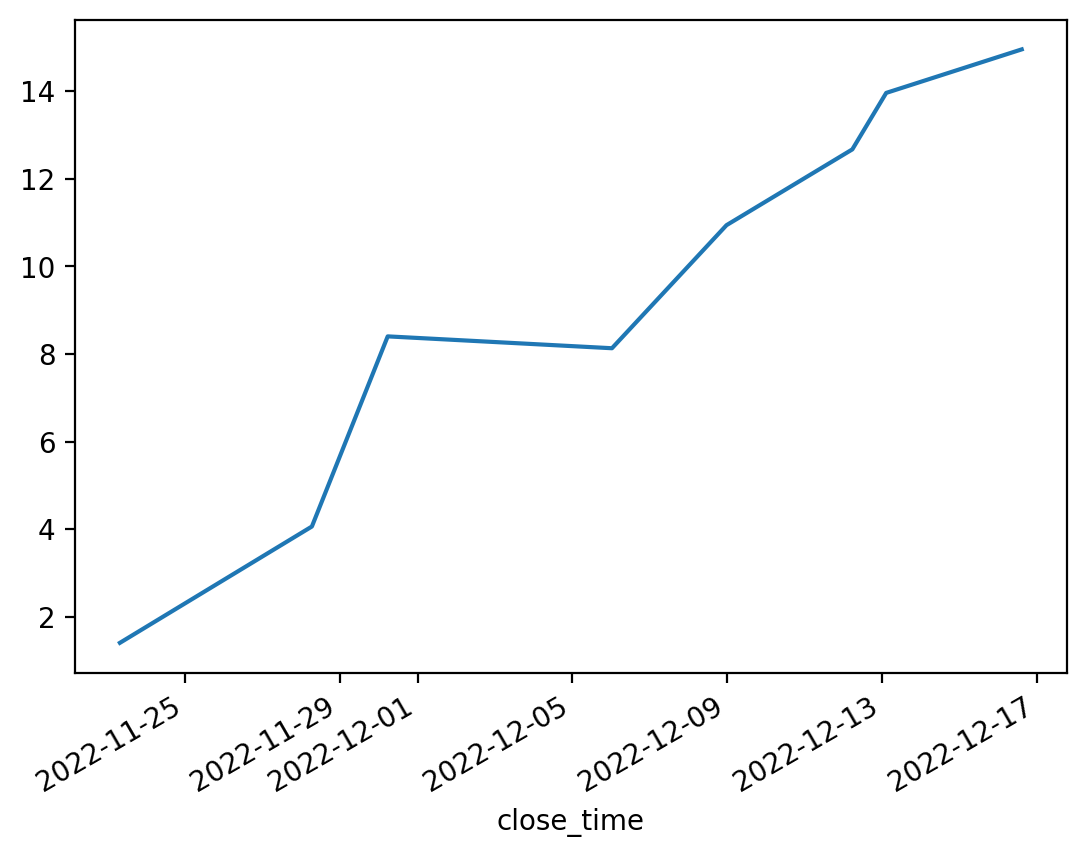

In [119]:
trades_df["profit"].cumsum().plot()

In [120]:
print("Backtesting summary:")
print(f"Trades: %d" % len(trades_df))
print("Profit Sum: %.3f%%" % trades_df.profit.sum())
print("Max Trade profit.: %.3f%%" % trades_df.profit.max())
print("Min Trade profit.: %.3f%%" % trades_df.profit.min())
print(f"Profit Per Trade(Avg.):  %.3f%%" % trades_df.profit.mean())

Backtesting summary:
Trades: 8
Profit Sum: 14.952%
Max Trade profit.: 4.340%
Min Trade profit.: -0.271%
Profit Per Trade(Avg.):  1.869%
